In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import warnings
import sccoda
import anndata
import scanpy as sc
import rpy2
import os
import matplotlib

# scCODA Imports
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import warnings

from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

warnings.filterwarnings("ignore")


In [2]:
# load the data
SPN_scanpy = sc.read_h5ad("/endosome/work/Neuroinformatics_Core/gkonop/03_INTEGRATE_ALL/SPN/ANNOTATED/GB_SPN_AllSpecies_integrated_annotated.h5ad")

# check
print(SPN_scanpy.obs["orig.ident"].value_counts())  # check how many SPNs are in each sample
print(SPN_scanpy.obs["Species"].value_counts())
print(SPN_scanpy.obs["intronRat"].value_counts())
print(SPN_scanpy.obs["Age"].value_counts())
print(SPN_scanpy.obs["Sex"].value_counts())
print(SPN_scanpy.obs["Tissue"].value_counts())
print(SPN_scanpy.obs["newannot_2"].value_counts())  # Change to newannot for initial check

# Convert the 'newannot_2' column to categorical
SPN_scanpy.obs['newannot'] = SPN_scanpy.obs['newannot'].astype('category')
SPN_scanpy.obs['newannot_2'] = SPN_scanpy.obs['newannot_2'].astype('category')

# Make sure gene and cell names are OK
SPN_scanpy.obs
SPN_scanpy.var

# save counts to layers
SPN_scanpy.layers['counts'] = SPN_scanpy.raw.X.copy()  # raw counts
SPN_scanpy.layers['log1p'] = SPN_scanpy.X.copy()

# Remove MT and RP genes
mt_genes = SPN_scanpy.var_names[SPN_scanpy.var_names.str.startswith('MT-')]
not_mt_genes = [not g for g in SPN_scanpy.var_names.isin(mt_genes)]
SPN_scanpy = SPN_scanpy[:, not_mt_genes].copy()

RP_genes = SPN_scanpy.var_names[SPN_scanpy.var_names.str.startswith('RP')]
not_RP_genes = [not g for g in SPN_scanpy.var_names.isin(RP_genes)]
SPN_scanpy = SPN_scanpy[:, not_RP_genes].copy()

# check
SPN_scanpy  # 244824 cells 17309 genes


Caud_3           12034
Caud_2           10483
SRR11921010       9925
SRR11921009       8839
Caud_5            8744
                 ...  
Sample_243000      789
Sample_242999      614
Sample_20          472
SRR13808459        358
Sample_242939      262
Name: orig.ident, Length: 65, dtype: int64
Bat         55889
Mouse       51372
Macaque     43548
Marmoset    41156
Human       22854
Chimp       18785
Ferret      11220
Name: Species, dtype: int64
0.800000    28
0.777778    17
0.750000    16
0.809524    10
0.818182     9
            ..
0.777857     1
0.803353     1
0.783727     1
0.814368     1
0.804678     1
Name: intronRat, Length: 191443, dtype: int64
3.0     9800
16.0    7706
9.0     7295
5.0     7227
65.0    6174
7.0     4924
37.0    4491
24.9    4463
62.0    4040
36.0    3135
40.1    3013
40.0    2802
14.0    2532
60.0    2500
59.0    2282
49.0    2024
3.5     1961
44.1    1940
4.0     1745
34.9    1743
69.0    1713
51.0    1319
12.0     358
Name: Age, dtype: int64
NA        167222

AnnData object with n_obs × n_vars = 244824 × 17309
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'intronRat', 'Tissue', 'Species', 'Brain_Region', 'Age', 'PMI', 'Sex', 'Race', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'doublet_status', 'id', 'integrated_snn_res.2', 'SCT_snn_res.1', 'newannot', 'SCT_snn_res.0.1', 'integrated_snn_res.1', 'SCT_snn_res.0.3', 'log10UMI', 'type', 'integrated_snn_res.0.1', 'integrated_snn_res.0.5', 'nCount_integrated', 'nFeature_integrated', 'sex', 'age', 'Individual', 'animal', 'BICCN_id', 'alt_id', 'mtperc', 'tissue', 'broad_annot', 'integrated_snn_res.0.2', 'newannot_2'
    var: 'features'
    layers: 'counts', 'log1p'

In [3]:
# change working dir
os.chdir('/endosome/work/Neuroinformatics_Core/gkonop/06_QC_plots/')
# check
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /endosome/work/Neuroinformatics_Core/gkonop/06_QC_plots


## Dimensionality reduction

In [4]:
# Select HVGs
sc.pp.highly_variable_genes(SPN_scanpy, flavor='seurat', n_top_genes=1500)

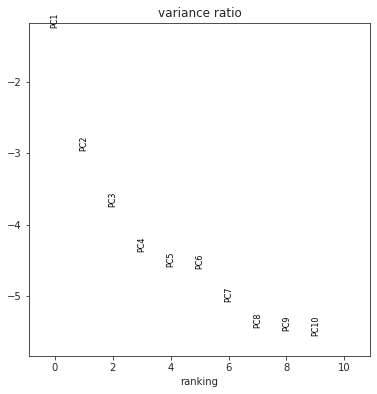

In [5]:
# PCA
plt.rcParams['figure.figsize']=(6,6) #rescale figures
n_pcs=10
sc.pp.pca(SPN_scanpy, n_comps=n_pcs, use_highly_variable=True, 
          svd_solver='arpack',random_state=1)
sc.pl.pca_variance_ratio(SPN_scanpy,n_pcs, log=True)

In [6]:
# Neighborhood graph and UMAP
sc.pp.neighbors(SPN_scanpy,n_pcs=10,random_state=1,metric='euclidean')
sc.tl.umap(SPN_scanpy,random_state=1)

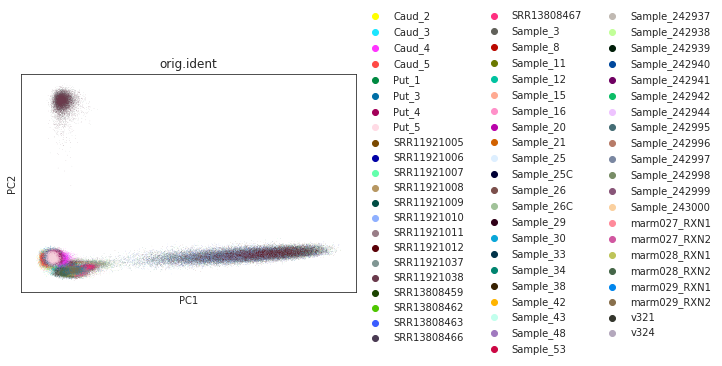

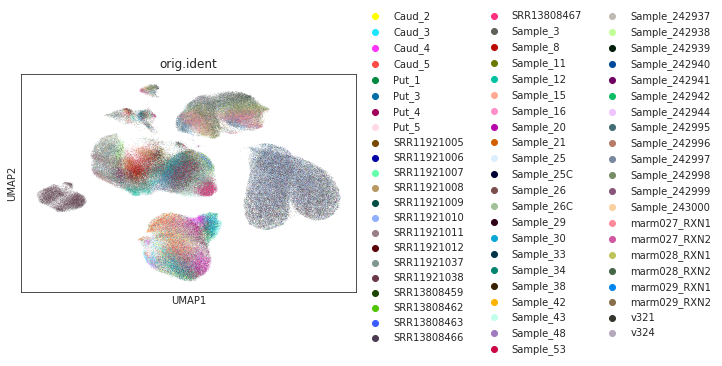

In [7]:
# Inspect the data
sc.pl.pca_scatter(SPN_scanpy, color='orig.ident')
sc.pl.umap(SPN_scanpy, color='orig.ident')

## Clustering

In [8]:
# Run louvain
sc.tl.louvain(SPN_scanpy, resolution=0.1, key_added='louvain_r2', random_state=1)

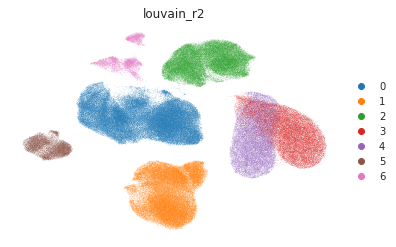

In [9]:
sc.pl.umap(SPN_scanpy,color=['louvain_r2'],frameon=False)

## Find markers

In [10]:
sc.tl.dendrogram(SPN_scanpy, groupby='louvain_r2',linkage_method='average')

In [11]:
dimensions = SPN_scanpy.X.shape
print(f"Dimensions of SPN_scanpy.X: {dimensions}")

Dimensions of SPN_scanpy.X: (244824, 17309)


In [12]:
sc.pp.log1p(SPN_scanpy)  # Log-transform the raw data
SPN_scanpy.layers['log1p'] = SPN_scanpy.X  # Store log-transformed data in a new layer


In [13]:
sc.tl.rank_genes_groups(SPN_scanpy, groupby='louvain_r2',
                        key_added='DE_2', method='wilcoxon', pts=True, 
                        layer='log1p', use_raw=False)


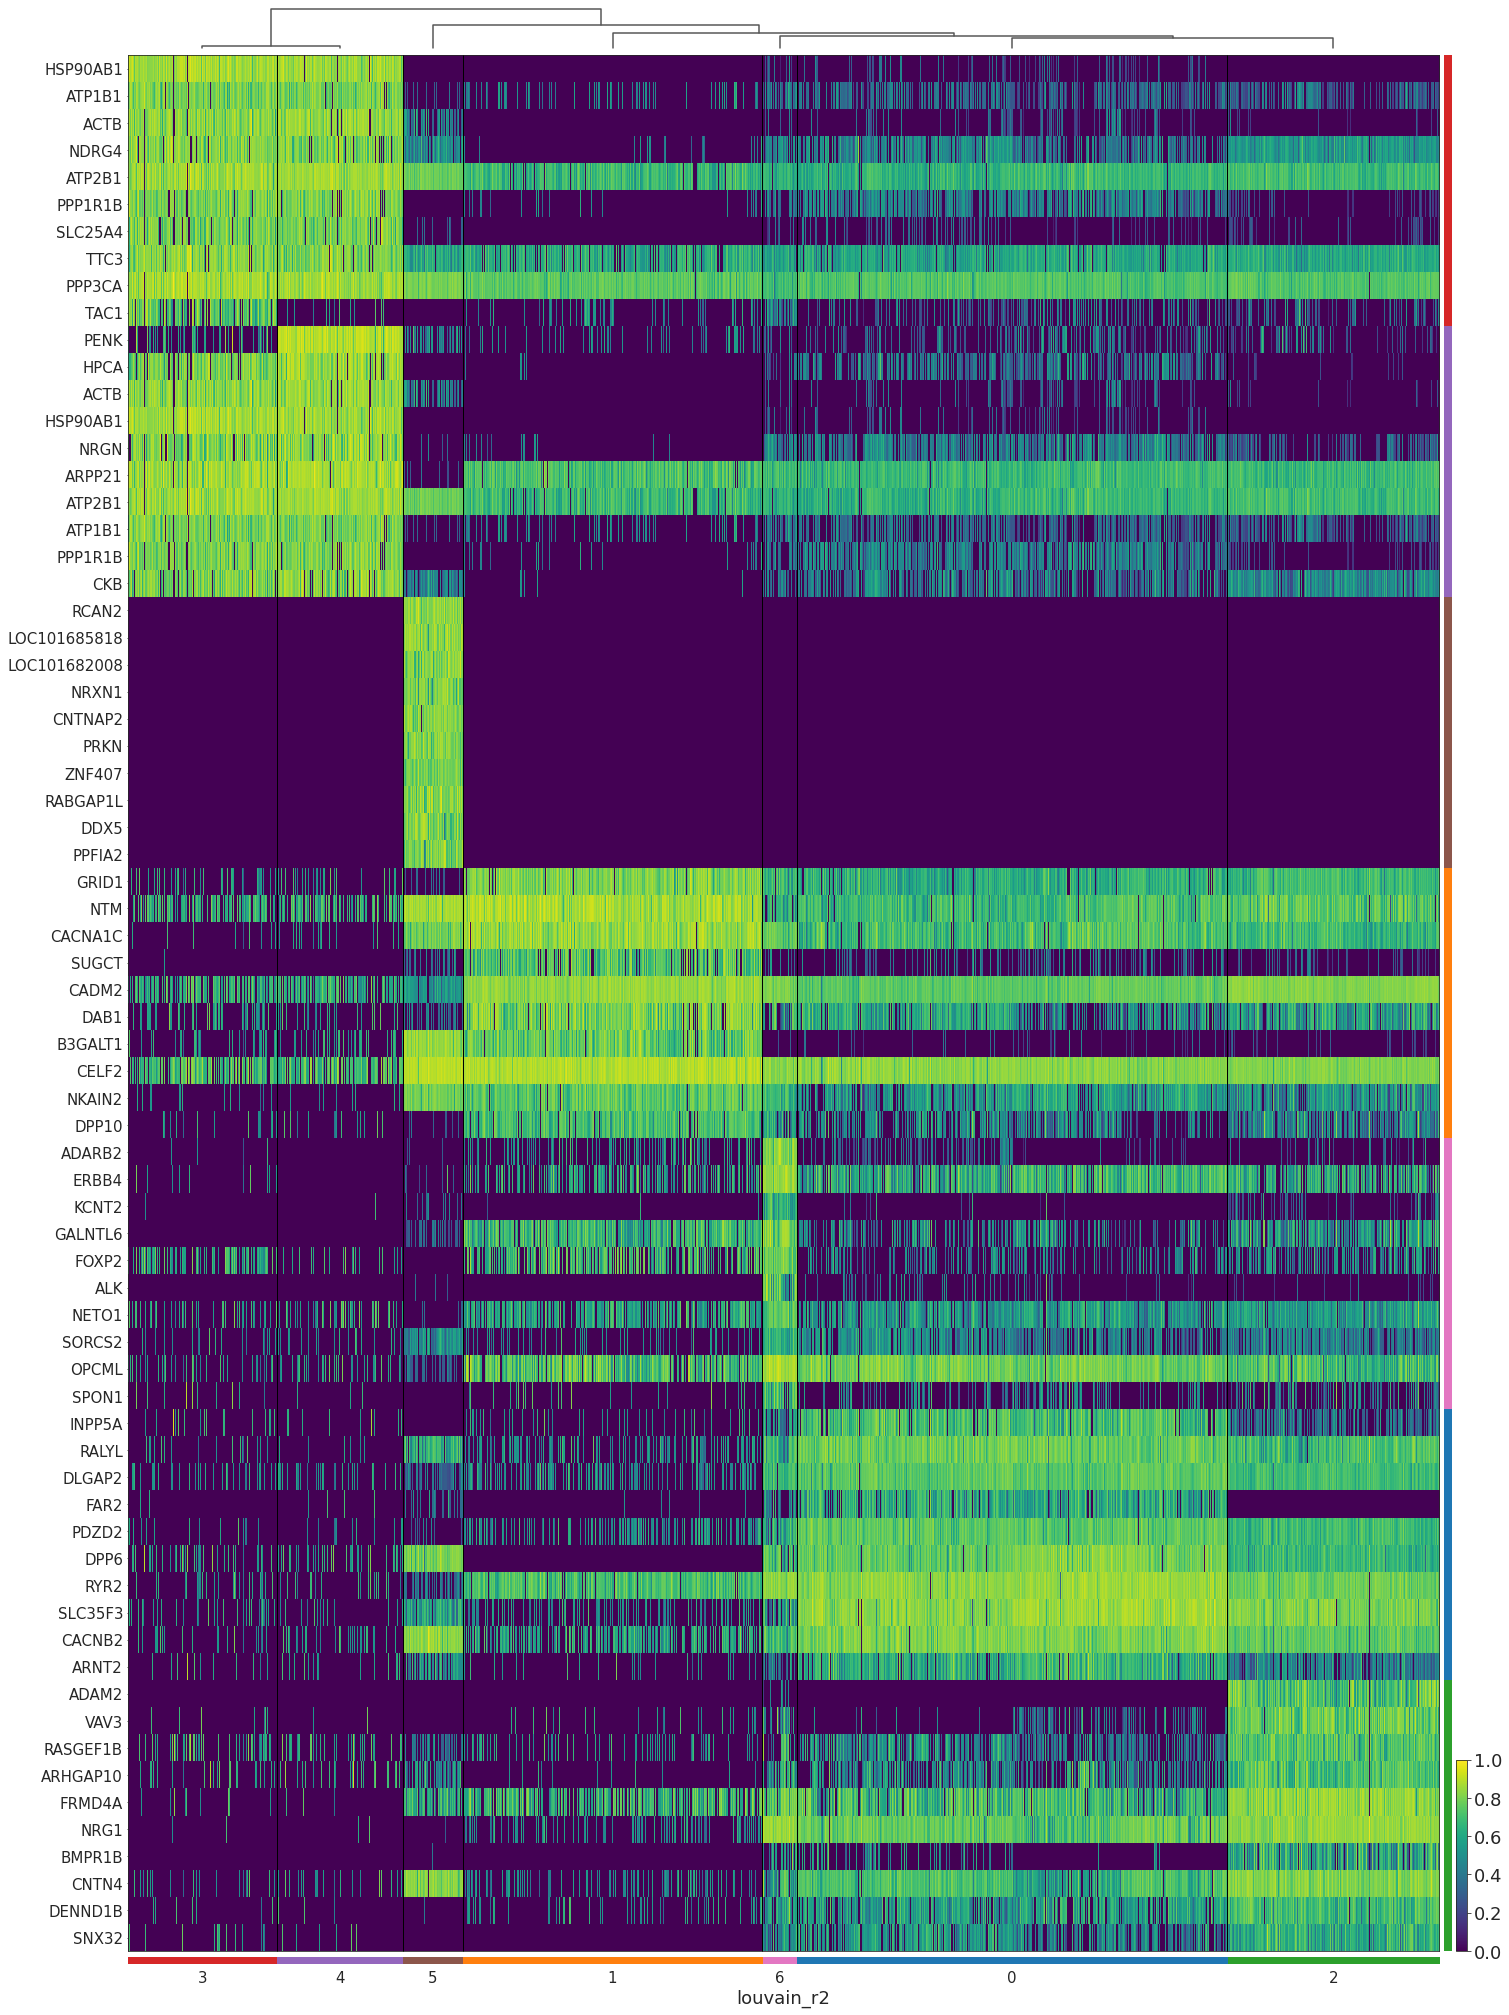

In [14]:
plt.rcParams.update({'font.size': 18})
sc.pl.rank_genes_groups_heatmap(SPN_scanpy, n_genes=10, 
                                standard_scale='var', 
                                groupby='louvain_r2',
                                key='DE_2',
                                use_raw=False,
                                cmap='viridis',
                                swap_axes=True,figsize=(24,36),
                                show_gene_labels=True,dendrogram=True,min_logfoldchange=0)

### scCODA - extract the count matrix which scCODA requires

In [15]:
# Subset Tissue 
SPN_scanpy_putamen = SPN_scanpy[SPN_scanpy.obs['Tissue'] == 'Putamen'].copy()
SPN_scanpy_caud = SPN_scanpy[SPN_scanpy.obs['Tissue'] == 'Caudate'].copy()

# Create a DataFrame from the AnnData object
metadata_df_put = SPN_scanpy_putamen.obs[['id', 'newannot_2', 'Species']].copy()
metadata_df_caud = SPN_scanpy_caud.obs[['id', 'newannot_2', 'Species']].copy()
metadata_df_all = SPN_scanpy.obs[['id', 'newannot_2', 'Species']].copy()

# Check unique id and Species pairs
unique_pairs_put = metadata_df_put[['id', 'Species']].drop_duplicates()
print("Unique id-Species pairs:")
print(unique_pairs_put)

# Similarly for other tissues
unique_pairs_caud = metadata_df_caud[['id', 'Species']].drop_duplicates()
unique_pairs_all = metadata_df_all[['id', 'Species']].drop_duplicates()

# Create a unique mapping from id to Species
id_species_mapping_put = unique_pairs_put.groupby('id').first().reset_index()
id_species_mapping_caud = unique_pairs_caud.groupby('id').first().reset_index()
id_species_mapping_all = unique_pairs_all.groupby('id').first().reset_index()

# Convert to a dictionary for easy lookup
id_species_dict_put = id_species_mapping_put.set_index('id')['Species'].to_dict()
id_species_dict_caud = id_species_mapping_caud.set_index('id')['Species'].to_dict()
id_species_dict_all = id_species_mapping_all.set_index('id')['Species'].to_dict()

# Map the species to the metadata_df using the generated dictionary
metadata_df_put['Species'] = metadata_df_put['id'].map(id_species_dict_put)
metadata_df_caud['Species'] = metadata_df_caud['id'].map(id_species_dict_caud)
metadata_df_all['Species'] = metadata_df_all['id'].map(id_species_dict_all)

# Count occurrences of each newannot_2 for each sample_id and species
## Putamen
count_df_put = metadata_df_put.groupby(['id', 'Species', 'newannot_2']).size().reset_index(name='count')

# Display the resulting DataFrame
print("Counts_df:")
print(count_df_put)

# Pivot the DataFrame to create the count matrix
cell_counts_put = count_df_put.pivot_table(index=['id', 'Species'], 
                                     columns='newannot_2', 
                                     values='count', 
                                     fill_value=0)

count_df_all = metadata_df_all.groupby(['id', 'Species', 'newannot_2']).size().reset_index(name='count')

# Caudate
# Count occurrences of each newannot_2 for each sample_id and species
count_df_caud = metadata_df_caud.groupby(['id', 'Species', 'newannot_2']).size().reset_index(name='count')

# Display the resulting DataFrame
print("Counts_df:")
print(count_df_caud)

# Pivot the DataFrame to create the count matrix
cell_counts_caud = count_df_caud.pivot_table(index=['id', 'Species'], 
                                     columns='newannot_2', 
                                     values='count', 
                                     fill_value=0)

# All
# Display the resulting DataFrame
print("Counts_df_all:")
print(count_df_all)

# Pivot the DataFrame to create the count matrix
cell_counts_all = count_df_all.pivot_table(index=['id', 'Species'], 
                                     columns='newannot_2', 
                                     values='count', 
                                     fill_value=0)

# Flatten MultiIndex columns if necessary
cell_counts_put.columns = [col if isinstance(col, str) else col[1] for col in cell_counts_put.columns]
cell_counts_caud.columns = [col if isinstance(col, str) else col[1] for col in cell_counts_caud.columns]
cell_counts_all.columns = [col if isinstance(col, str) else col[1] for col in cell_counts_all.columns]

# Reset the index to convert id and Species from index to columns
cell_counts_put.reset_index(inplace=True)
cell_counts_caud.reset_index(inplace=True)
cell_counts_all.reset_index(inplace=True)

# To ensure that species information is included, we will merge it back
cell_counts_put = cell_counts_put.merge(id_species_mapping_put, on='id', how='left')
cell_counts_caud = cell_counts_caud.merge(id_species_mapping_caud, on='id', how='left')
cell_counts_all = cell_counts_all.merge(id_species_mapping_all, on='id', how='left')

# Display the resulting DataFrame
print("Cell Counts DataFrame:")
print(cell_counts_put)
print(cell_counts_caud)
print(cell_counts_all)

# Drop specific columns by index
# Note: Indexing starts at 0, so adjust accordingly based on your DataFrame structure
columns_to_drop = [1]  

# Create a cleaned DataFrame by dropping the specified columns
cell_counts_put = cell_counts_put.drop(cell_counts_put.columns[columns_to_drop], axis=1)
cell_counts_caud = cell_counts_caud.drop(cell_counts_caud.columns[columns_to_drop], axis=1)
cell_counts_all = cell_counts_all.drop(cell_counts_all.columns[columns_to_drop], axis=1)

# Display the cleaned DataFrame
print("Cleaned Cell Counts DataFrame:")
print(cell_counts_put)
print(cell_counts_caud)
print(cell_counts_all)

# Check the columns again
print("Columns after reset_index:")
print(cell_counts_put.columns)
print(cell_counts_caud.columns)
print(cell_counts_all.columns)


Unique id-Species pairs:
                                                    id   Species
AGGGCCTTCAAACCCA-Sample_242937   Sample_242937_Putamen     Human
AACTTCTCAACGACTT-Sample_242938   Sample_242938_Putamen     Human
TCATTACGTCTACAGT-Sample_242939   Sample_242939_Putamen     Human
TCGATTTTCTACTATC-Sample_242940   Sample_242940_Putamen     Human
TCAGTTTGTAATACCC-Sample_242941   Sample_242941_Putamen     Human
GTTCGCTAGTACTGTC-Sample_242942   Sample_242942_Putamen     Human
TCAGTTTTCTTCGACC-Sample_242944   Sample_242944_Putamen     Human
CCACAAACAATACGAA-Sample_12           Sample_12_Putamen     Chimp
GTTGCGGTCTAGGCAT-Sample_16           Sample_16_Putamen     Chimp
CATGAGTTCTGGCCAG-Sample_21           Sample_21_Putamen     Chimp
AGAACCTCAACACGAG-Sample_26C         Sample_26C_Putamen     Chimp
CATCGCTAGATTACCC-Sample_3             Sample_3_Putamen     Chimp
TATTGCTCAGGCCCTA-Sample_8             Sample_8_Putamen     Chimp
CTCATCGTCCTCATAT-Sample_26           Sample_26_Putamen   Macaque


In [16]:
# Now convert to scCODA format 
data_SPN_put = dat.from_pandas(cell_counts_put, covariate_columns=["id", "Species_y"]) 
data_SPN_caud = dat.from_pandas(cell_counts_caud, covariate_columns=["id", "Species_y"]) 
data_SPN_all = dat.from_pandas(cell_counts_all, covariate_columns=["id", "Species_y"]) 

# check
print(data_SPN_put.X)
print(data_SPN_put.obs)
print(data_SPN_caud.X)
print(data_SPN_caud.obs)
print(data_SPN_all.X)
print(data_SPN_all.obs)


[[2150   75 2281]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [1977   66 1796]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [2566   51 2637]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [2403   44 2380]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [ 229  106 1423]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [ 271   87 1522]
 [   0    0    0]
 [   0    0    0]
 [ 688   88  967]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [1290  134 1711]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [ 954  128 1042]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [ 857   74 1059]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [ 619   78  771]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    

### scCODA - Compositional data visualization

<Axes: title={'center': 'id'}, ylabel='Proportion'>

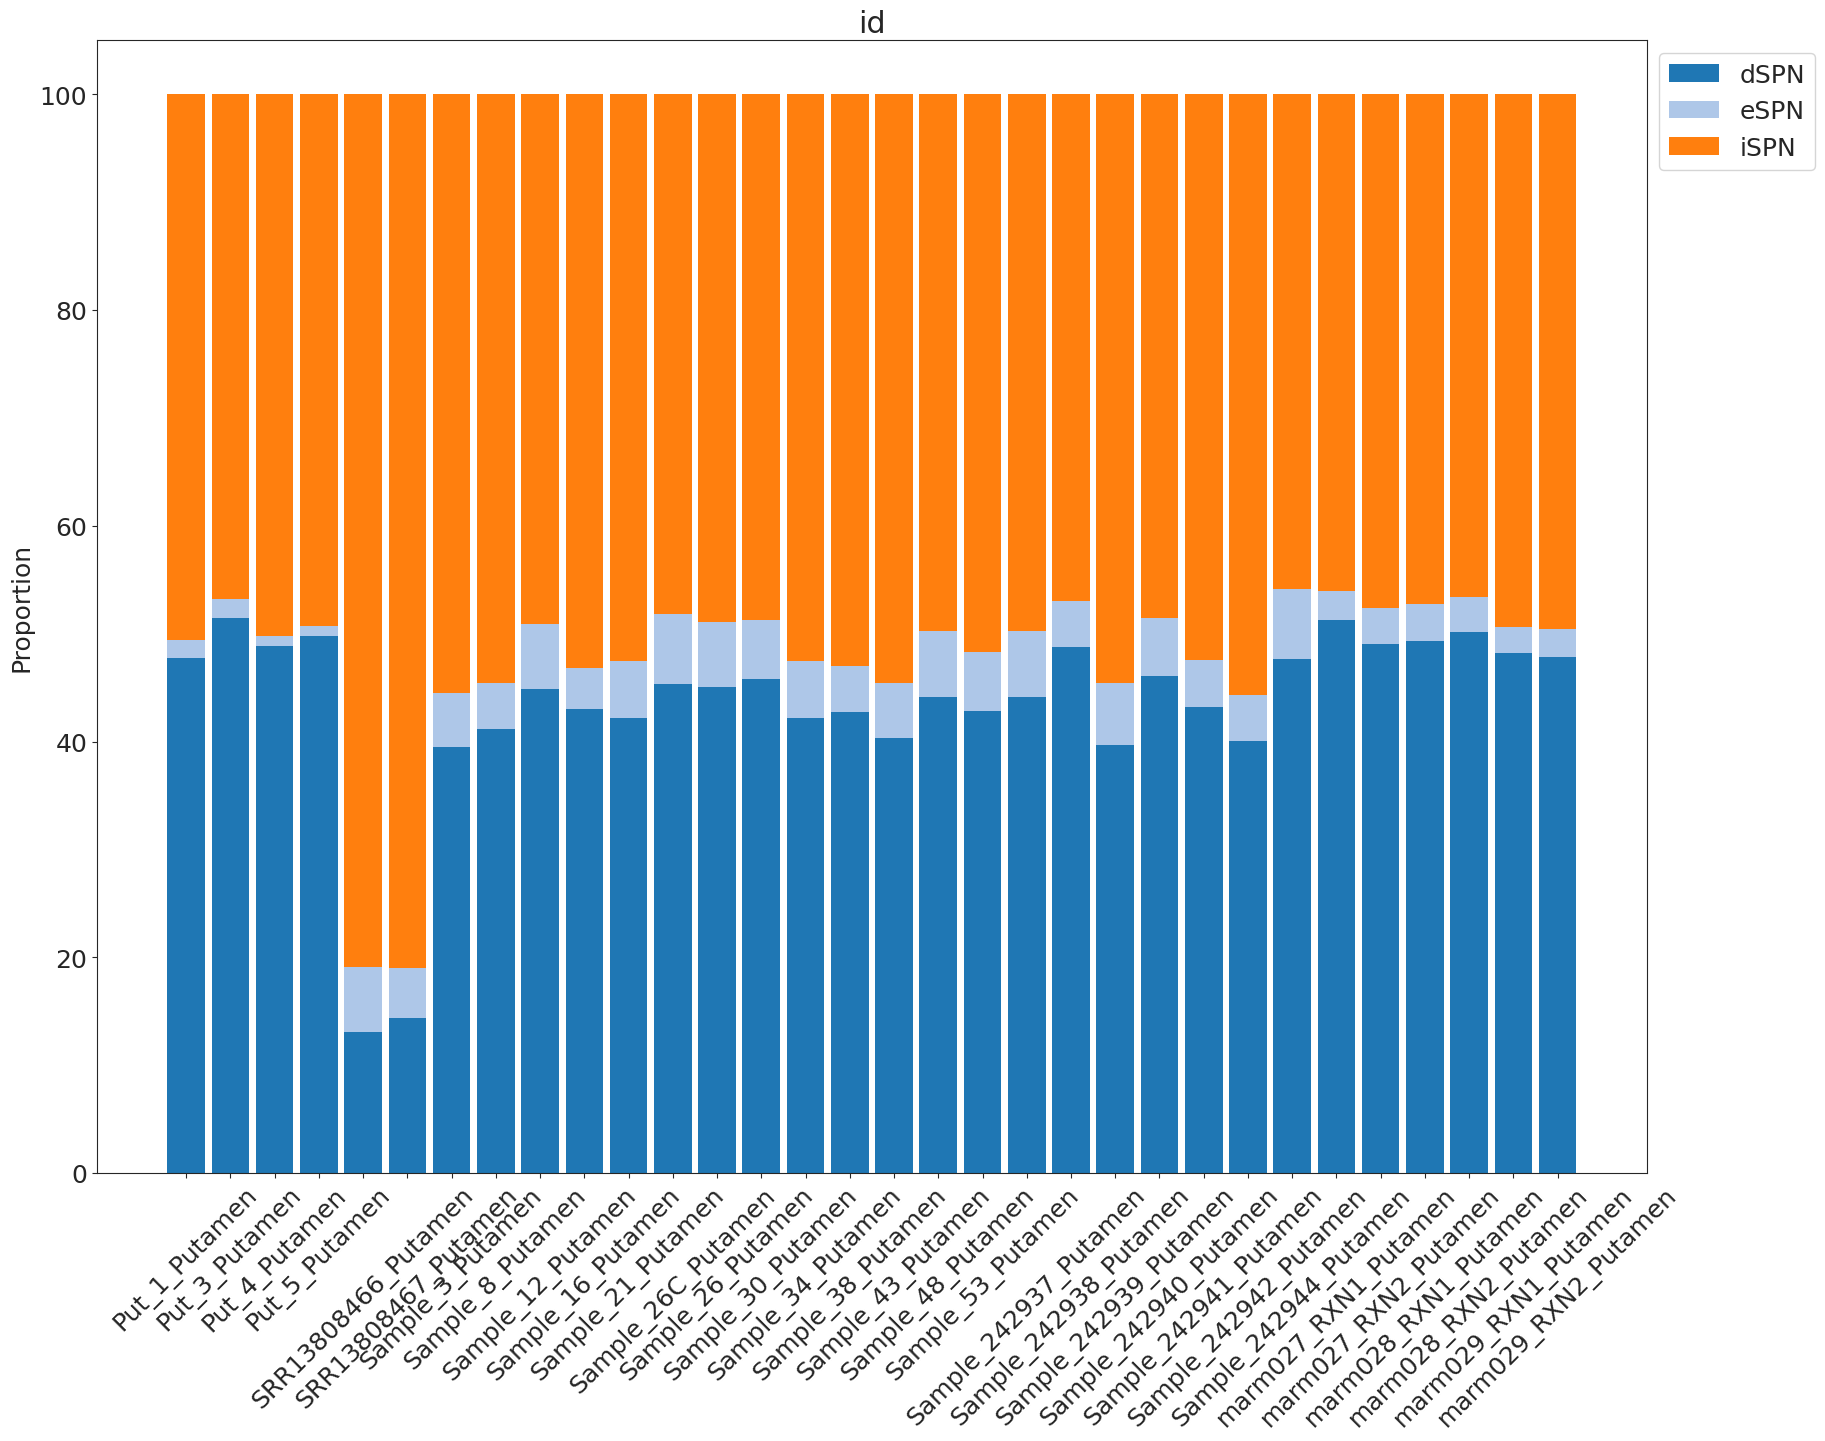

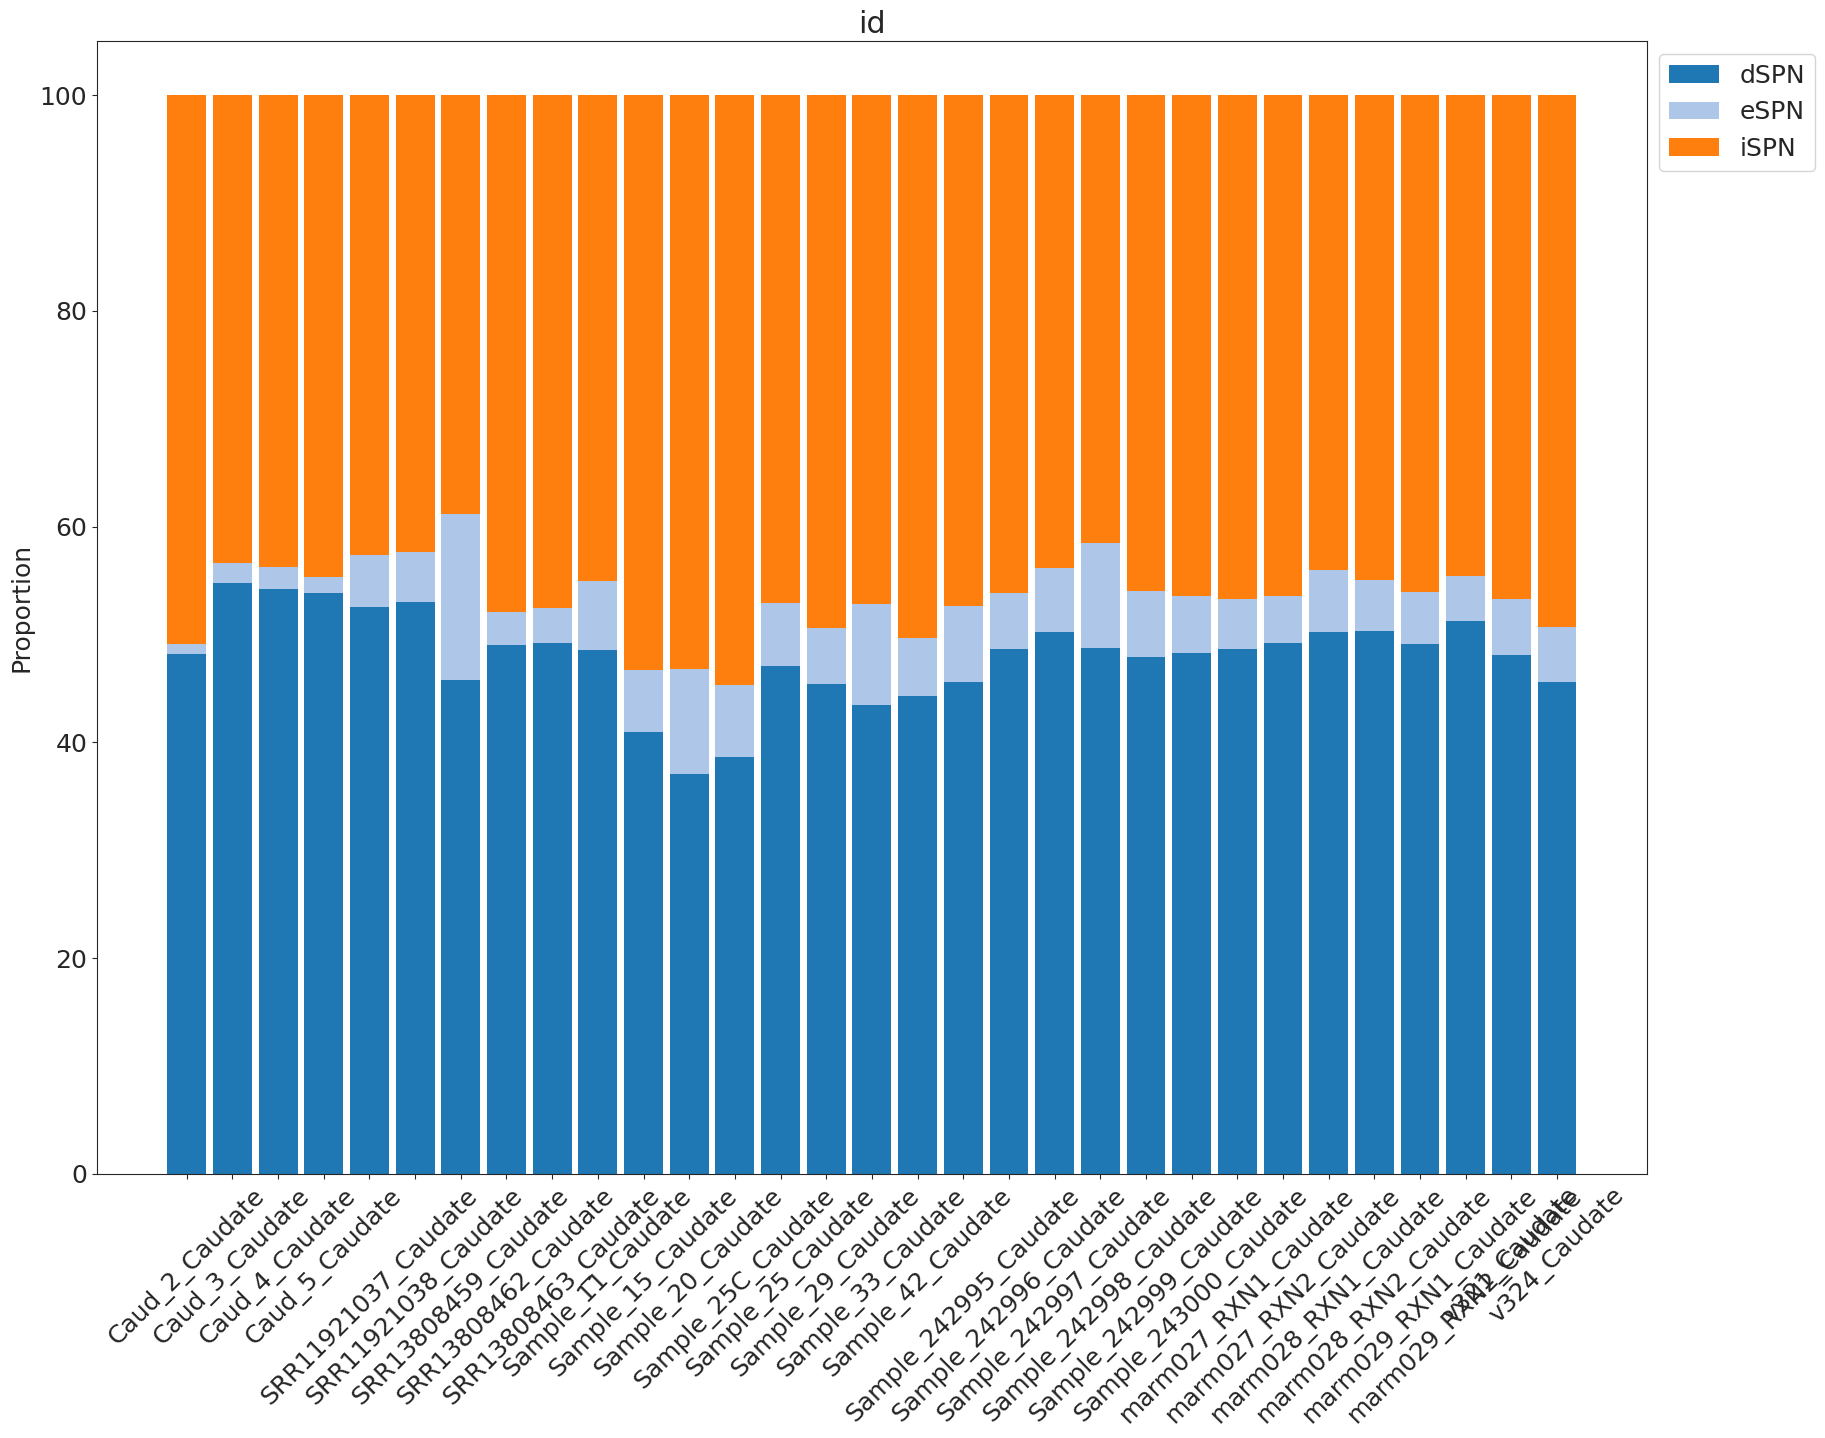

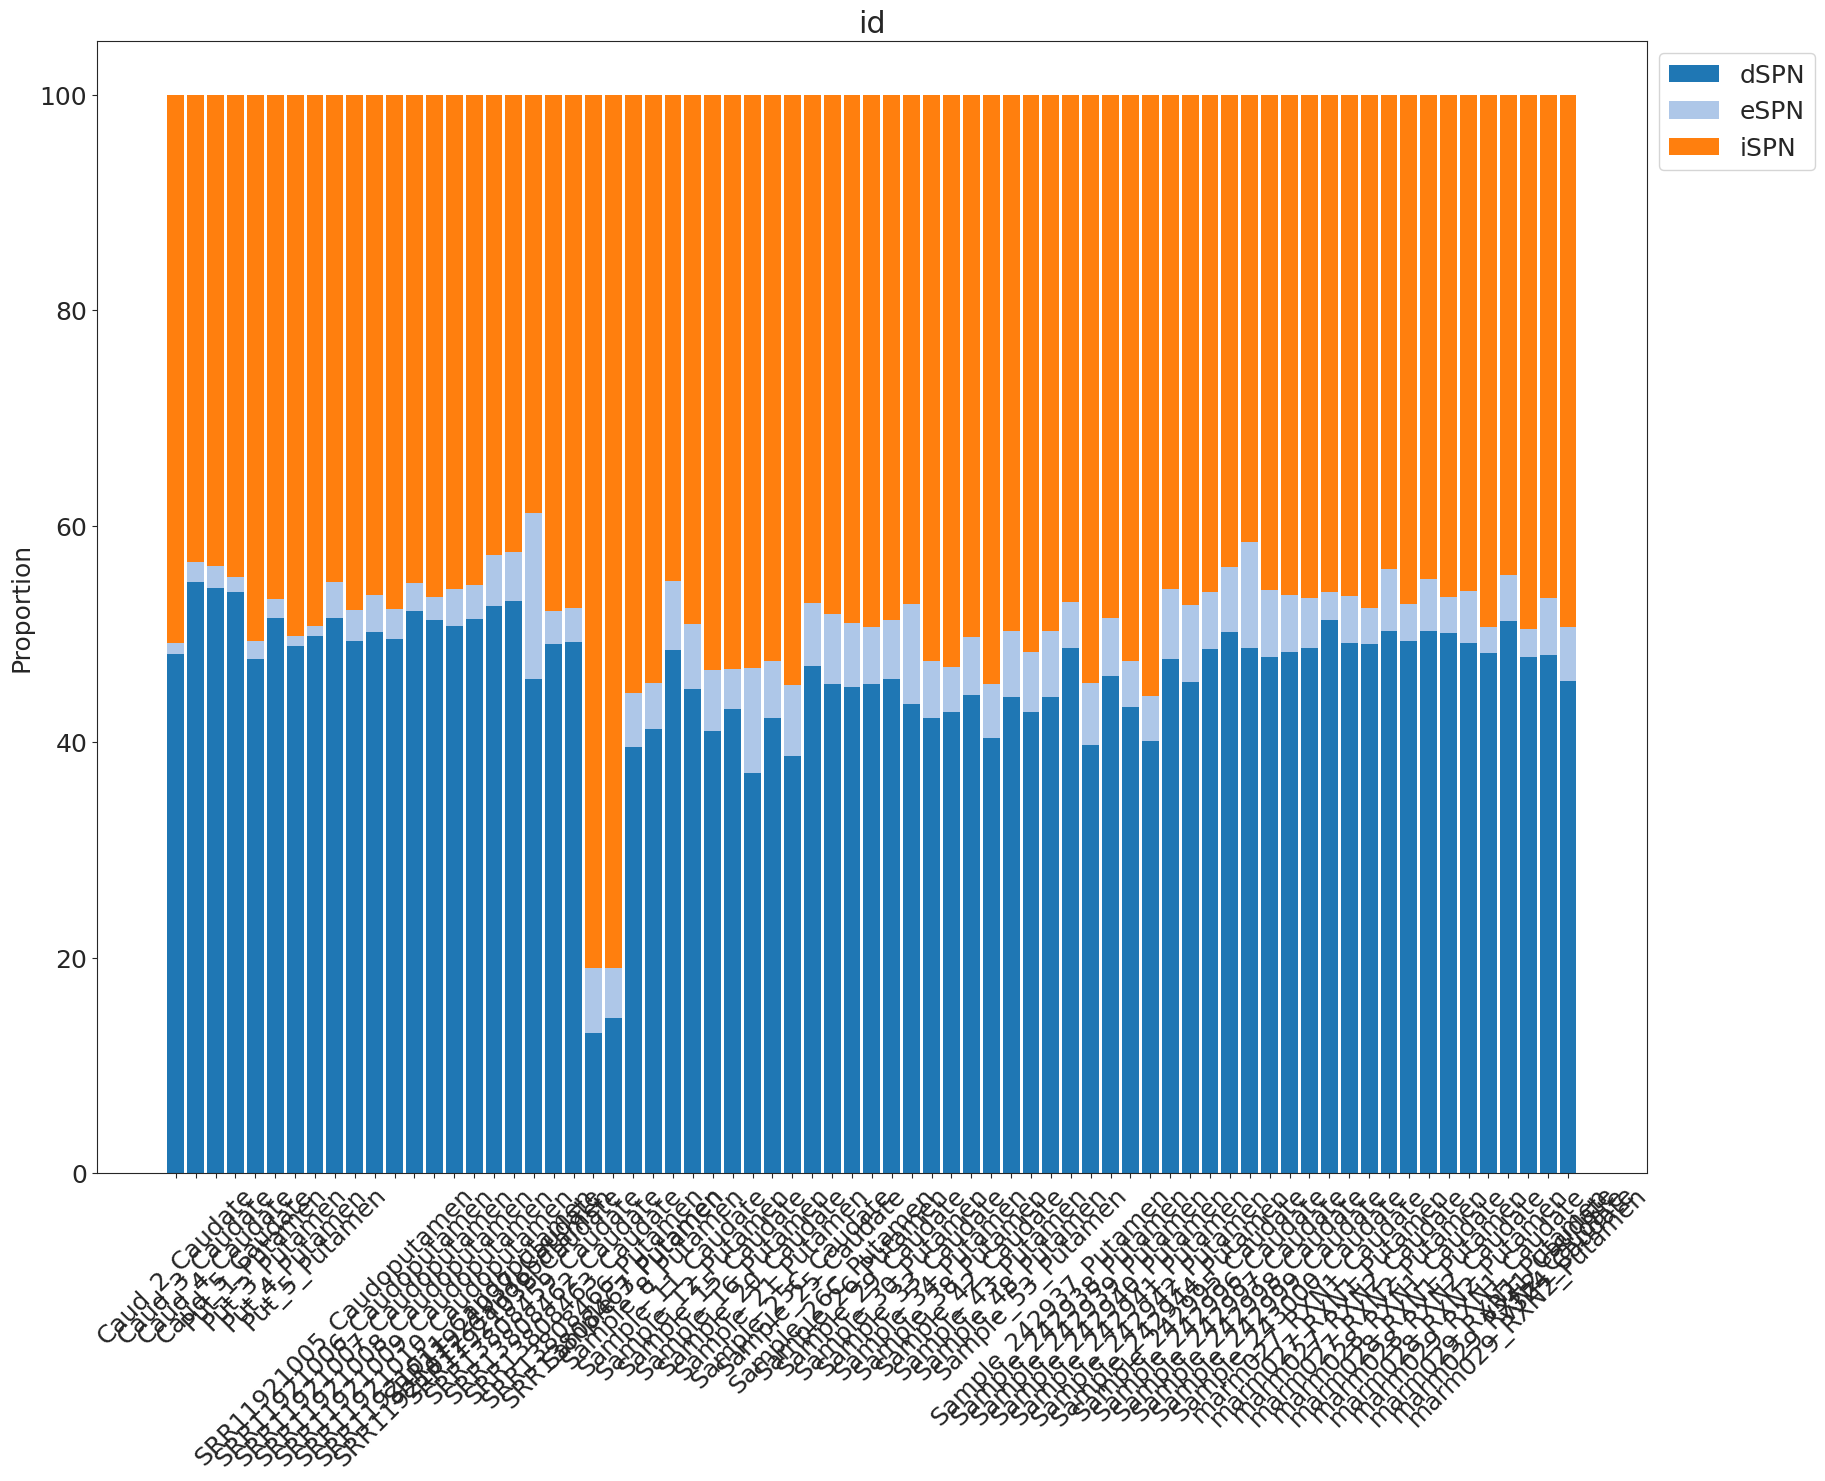

In [17]:
# Stacked barplot for the levels of sample_id
viz.stacked_barplot(data_SPN_put, feature_name="id", figsize=(20, 15))
viz.stacked_barplot(data_SPN_caud, feature_name="id", figsize=(20, 15))
viz.stacked_barplot(data_SPN_all, feature_name="id", figsize=(20, 15))

<Axes: title={'center': 'Species_y'}, ylabel='Proportion'>

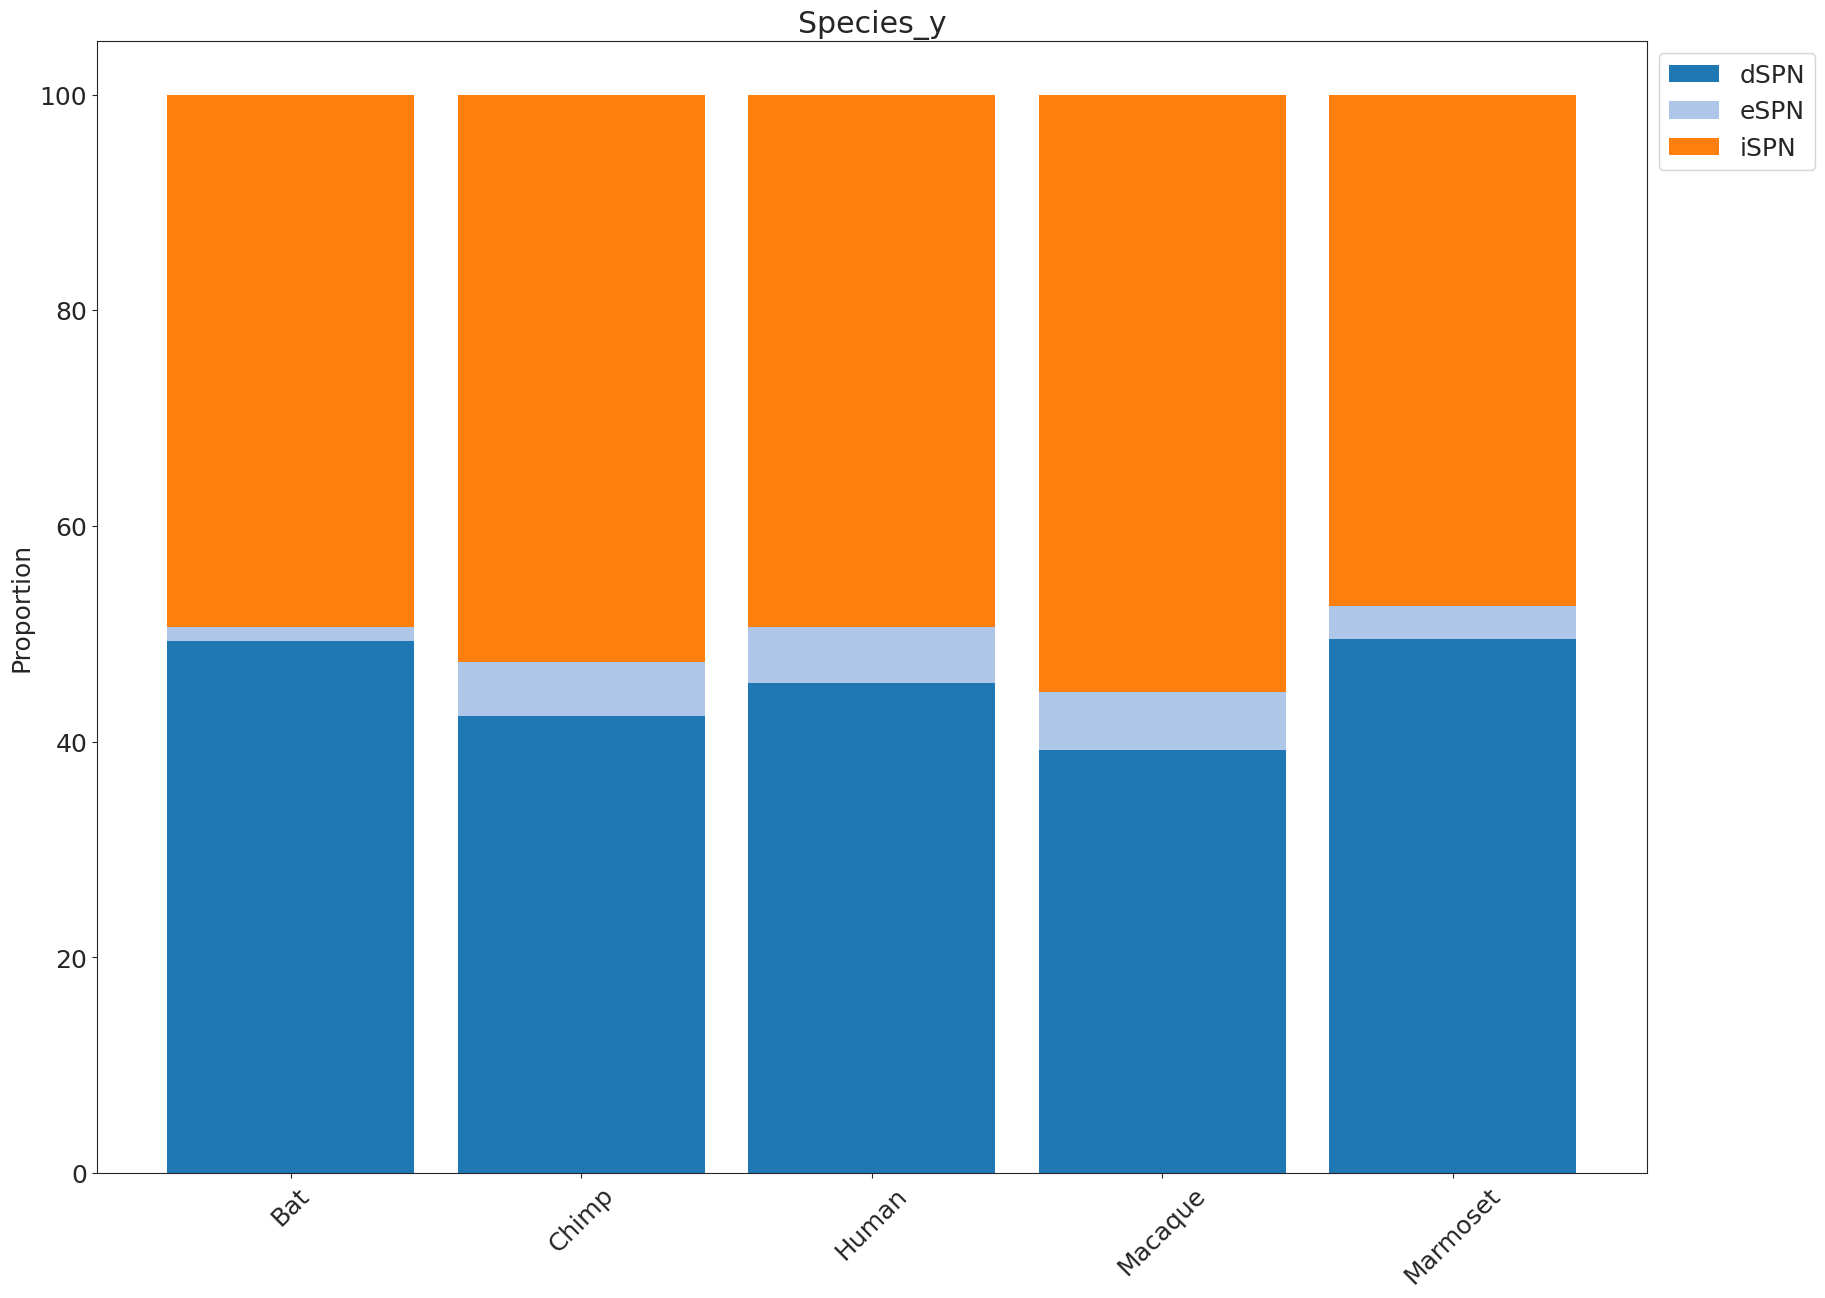

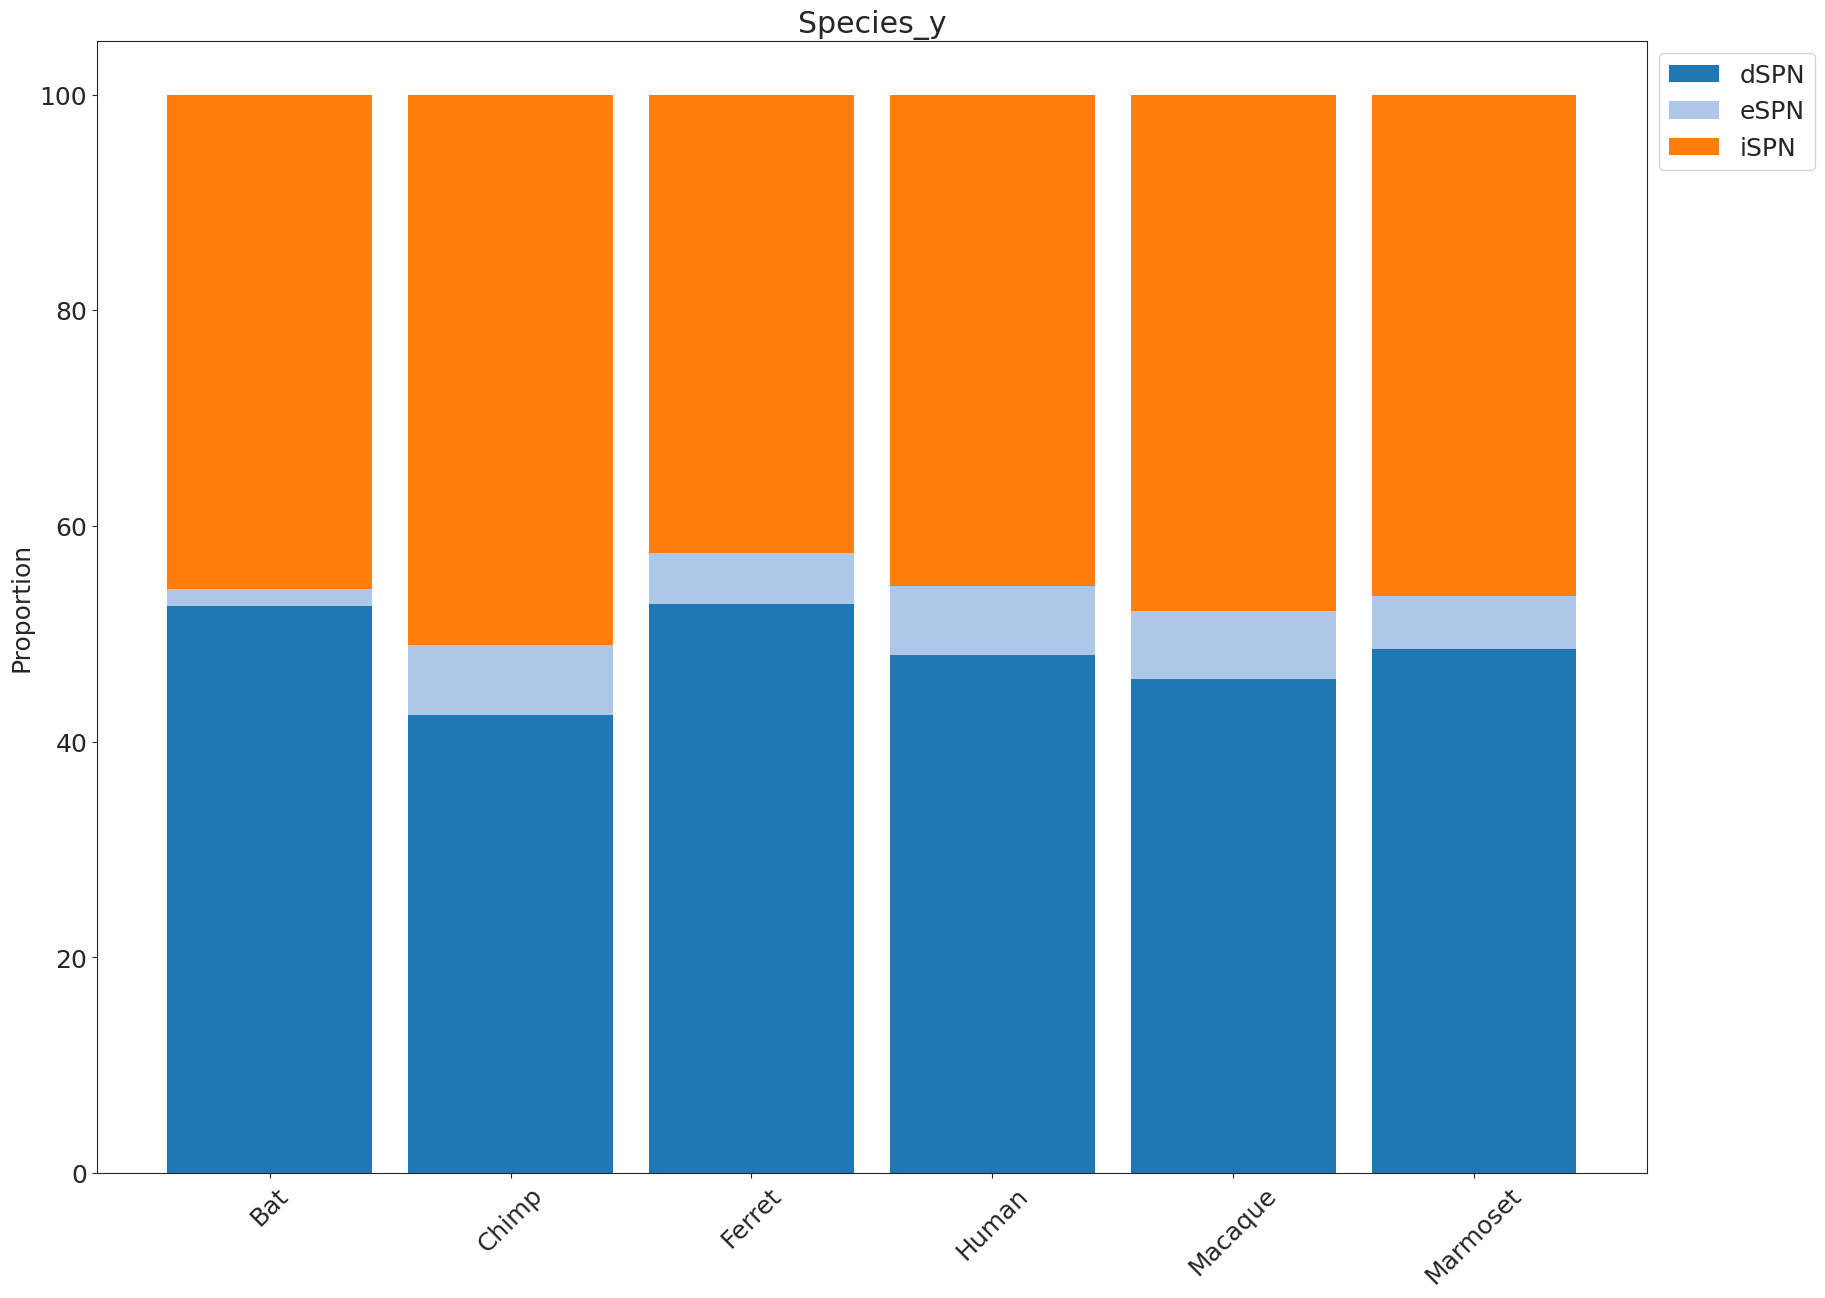

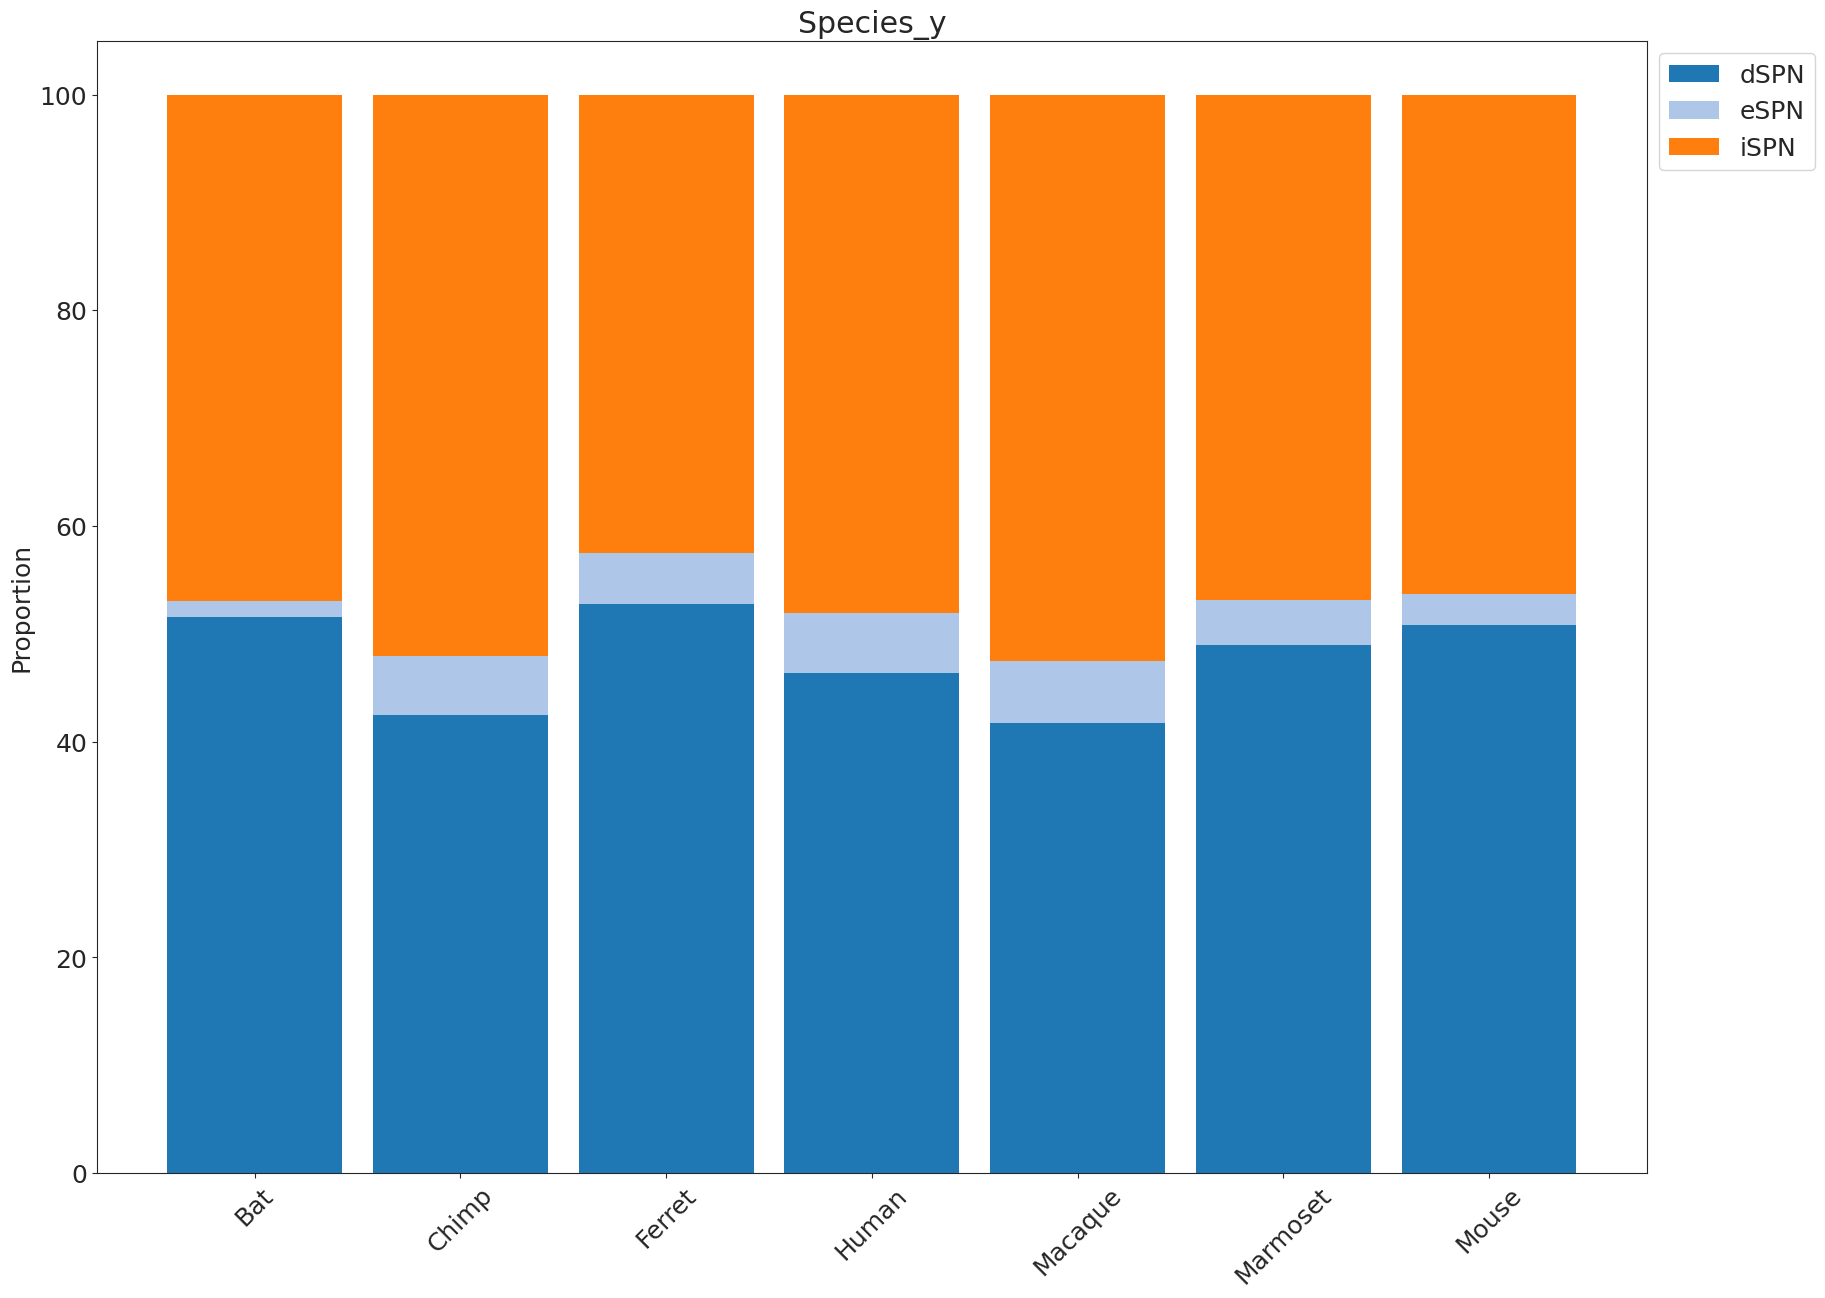

In [18]:
# Stacked barplot for the levels of "Species"
viz.stacked_barplot(data_SPN_put, feature_name="Species_y", figsize=(20, 15))
viz.stacked_barplot(data_SPN_caud, feature_name="Species_y", figsize=(20, 15))
viz.stacked_barplot(data_SPN_all, feature_name="Species_y", figsize=(20, 15))

### scCODA - Finding a reference cell type
The scCODA model requires a cell type to be set as the reference category. However, choosing this cell type is often difficult. A good first choice is a referenece cell type that closely preserves the changes in relative abundance during the compositional analysis.

For this, it is important that the reference cell type is not rare, to avoid large relative changes being caused by small absolute changes. Also, the relative abundance of the reference should vary as little as possible across all samples.

The visualization viz.rel_abundance_dispersion_plot shows the presence (share of non-zero samples) over all samples for each cell type versus its dispersion in relative abundance. Cell types that have a higher presence than a certain threshold (default 0.9) are suitable candidates for the reference and thus colored.

In [19]:
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /endosome/work/Neuroinformatics_Core/gkonop/06_QC_plots


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


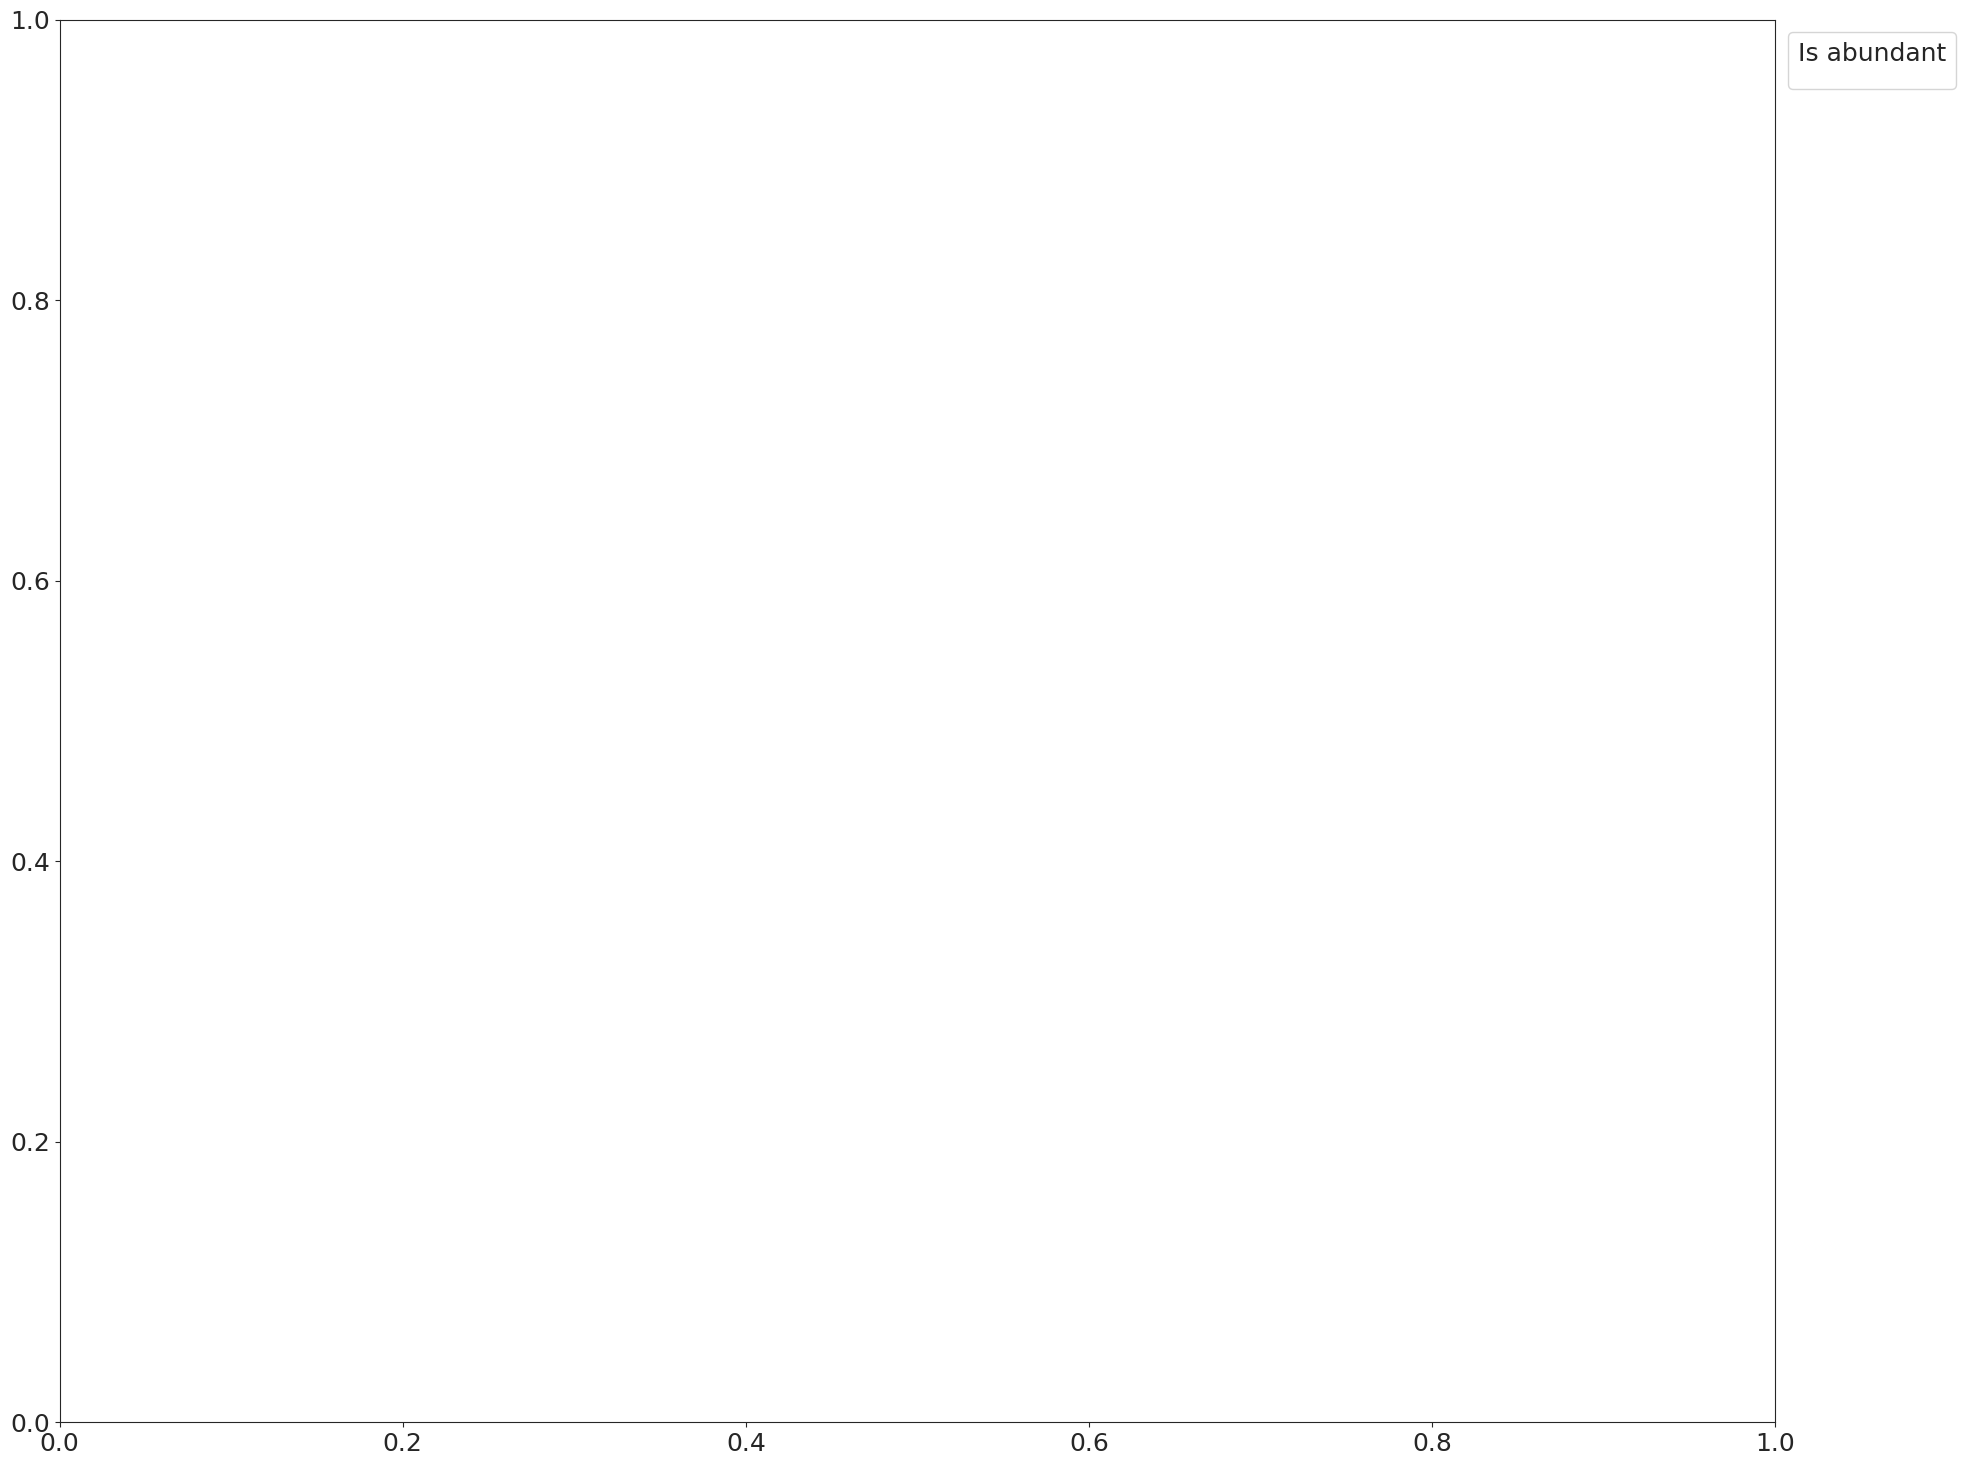

In [20]:
import matplotlib.pyplot as plt

# Create the relative abundance dispersion plot
viz.rel_abundance_dispersion_plot(
    data=data_SPN_all,
    abundant_threshold=0.9,
    figsize=(20, 15)
)
plt.show()

### scCODA - Model

In [34]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# change human as the control category: C(NameOfTheColumnofSpecies, Treatment('Human'))
# C(): This function is used to specify categorical variables in the formula. It tells the model to treat Species_y as a categorical variable.
# use putamen only
model_putamen = mod.CompositionalAnalysis(data_SPN_put, formula="C(Species_y, Treatment('Human'))", reference_cell_type="iSPN")
putamen_results = model_putamen.sample_hmc()
putamen_results.set_fdr(0.2)
putamen_results.summary_extended()

# Run the function and inspect the raw output
putamen_raw_results = putamen_results.credible_effects(data_SPN_put)
print(putamen_raw_results)


Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [02:14<00:00, 149.03it/s]


MCMC sampling finished. (174.245 sec)
Acceptance rate: 60.2%
Compositional Analysis summary (extended):

Data: 160 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Human'))
Spike-and-slab threshold: 0.879

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 174.245 sec. Acceptance rate: 60.2%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 2.939   2.428    3.446  0.275       240.278905
eSPN                 1.238   0.885    1.610  0.194        43.851124
iSPN                 3.025   2.536    3.512  0.259       261.857471


Effects:
                                                        Final Parameter  \
Covariate                                    Cell Type                    
C(Species_y, Treatment('Human'))[T.Bat]      dSPN              0.000000   
                                             eSPN             -0.513576   
  

In [35]:
# change human as the control category: C(NameOfTheColumnofSpecies, Treatment('Human'))
# C(): This function is used to specify categorical variables in the formula. It tells the model to treat Species_y as a categorical variable.
# use caudate only
model_caudate = mod.CompositionalAnalysis(data_SPN_caud, formula="C(Species_y, Treatment('Human'))", reference_cell_type="iSPN")
caudate_results = model_caudate.sample_hmc()
caudate_results.summary_extended()
caudate_results.set_fdr(0.2)
# Run the function and inspect the raw output
caudate_raw_results = caudate_results.credible_effects(data_SPN_caud)
print(caudate_raw_results)


Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:53<00:00, 176.24it/s]


MCMC sampling finished. (146.009 sec)
Acceptance rate: 42.6%
Compositional Analysis summary (extended):

Data: 186 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Human'))
Spike-and-slab threshold: 1.000

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 146.009 sec. Acceptance rate: 42.6%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 4.398   3.830    5.003  0.315       273.906460
eSPN                 2.488   1.990    2.968  0.261        40.560174
iSPN                 4.339   3.764    4.907  0.306       258.213474


Effects:
                                                        Final Parameter  \
Covariate                                    Cell Type                    
C(Species_y, Treatment('Human'))[T.Bat]      dSPN              0.000000   
                                             eSPN             -0.904038   
  

In [36]:
# all
model_all = mod.CompositionalAnalysis(data_SPN_all, formula="C(Species_y, Treatment('Human'))", reference_cell_type="iSPN")
all_results = model_all.sample_hmc()

all_results.summary_extended()
all_results.set_fdr(0.2)
# Run the function and inspect the raw output
all_raw_results = all_results.credible_effects(data_SPN_all)
print(all_raw_results)

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:27<00:00, 96.34it/s] 


MCMC sampling finished. (260.640 sec)
Acceptance rate: 64.7%
Compositional Analysis summary (extended):

Data: 497 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Human'))
Spike-and-slab threshold: 0.999

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 260.640 sec. Acceptance rate: 64.7%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 2.870   2.489    3.288  0.213       222.667585
eSPN                 1.347   1.089    1.591  0.135        48.554166
iSPN                 2.870   2.489    3.246  0.202       222.667585


Effects:
                                                        Final Parameter  \
Covariate                                    Cell Type                    
C(Species_y, Treatment('Human'))[T.Bat]      dSPN               0.00000   
                                             eSPN              -0.49311   
  

In [39]:
# C(): This function is used to specify categorical variables in the formula. It tells the model to treat Species_y as a categorical variable.
# use caudate only
model_caudate = mod.CompositionalAnalysis(data_SPN_caud, formula="C(Species_y, Treatment('Chimp'))", reference_cell_type="iSPN")
caudate_results = model_caudate.sample_hmc()

caudate_results.summary_extended()
caudate_results.set_fdr(0.2)
# Run the function and inspect the raw output
caudate_raw_results = caudate_results.credible_effects(data_SPN_caud)
print(caudate_raw_results)

model_putamen = mod.CompositionalAnalysis(data_SPN_put, formula="C(Species_y, Treatment('Chimp'))", reference_cell_type="iSPN")
putamen_results = model_putamen.sample_hmc()
putamen_results.set_fdr(0.2)
putamen_results.summary_extended()

# Run the function and inspect the raw output
putamen_raw_results = putamen_results.credible_effects(data_SPN_put)
print(putamen_raw_results)


Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:59<00:00, 167.72it/s]


MCMC sampling finished. (150.148 sec)
Acceptance rate: 63.1%
Compositional Analysis summary (extended):

Data: 186 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Chimp'))
Spike-and-slab threshold: 0.999

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 150.148 sec. Acceptance rate: 63.1%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 4.115   3.545    4.623  0.291       267.591056
eSPN                 2.282   1.825    2.733  0.243        42.796653
iSPN                 4.095   3.536    4.616  0.292       262.292398


Effects:
                                                        Final Parameter  \
Covariate                                    Cell Type                    
C(Species_y, Treatment('Chimp'))[T.Bat]      dSPN              0.000000   
                                             eSPN             -0.842926   
  

100%|██████████| 20000/20000 [01:53<00:00, 176.08it/s]


MCMC sampling finished. (148.533 sec)
Acceptance rate: 43.1%
Compositional Analysis summary (extended):

Data: 160 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Chimp'))
Spike-and-slab threshold: 0.878

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 148.533 sec. Acceptance rate: 43.1%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 2.948   2.434    3.442  0.273       239.394115
eSPN                 1.239   0.896    1.620  0.197        43.341526
iSPN                 3.043   2.552    3.506  0.259       263.251859


Effects:
                                                        Final Parameter  \
Covariate                                    Cell Type                    
C(Species_y, Treatment('Chimp'))[T.Bat]      dSPN              0.000000   
                                             eSPN             -0.508028   
  

In [40]:
# C(): This function is used to specify categorical variables in the formula. It tells the model to treat Species_y as a categorical variable.
# use caudate only
model_caudate = mod.CompositionalAnalysis(data_SPN_caud, formula="C(Species_y, Treatment('Macaque'))", reference_cell_type="iSPN")
caudate_results = model_caudate.sample_hmc()

caudate_results.summary_extended()
caudate_results.set_fdr(0.2)
# Run the function and inspect the raw output
caudate_raw_results = caudate_results.credible_effects(data_SPN_caud)
print(caudate_raw_results)

model_putamen = mod.CompositionalAnalysis(data_SPN_put, formula="C(Species_y, Treatment('Macaque'))", reference_cell_type="iSPN")
putamen_results = model_putamen.sample_hmc()
putamen_results.set_fdr(0.2)
putamen_results.summary_extended()

# Run the function and inspect the raw output
putamen_raw_results = putamen_results.credible_effects(data_SPN_put)
print(putamen_raw_results)


Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [02:11<00:00, 152.38it/s]


MCMC sampling finished. (162.399 sec)
Acceptance rate: 20.9%
Compositional Analysis summary (extended):

Data: 186 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Macaque'))
Spike-and-slab threshold: 0.992

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 162.399 sec. Acceptance rate: 20.9%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 4.370   3.939    4.784  0.187       271.273828
eSPN                 2.500   2.095    2.818  0.163        41.809716
iSPN                 4.326   3.897    4.729  0.185       259.596564


Effects:
                                                          Final Parameter  \
Covariate                                      Cell Type                    
C(Species_y, Treatment('Macaque'))[T.Bat]      dSPN              0.000000   
                                               eSPN             -1.00

100%|██████████| 20000/20000 [02:15<00:00, 147.22it/s]


MCMC sampling finished. (168.127 sec)
Acceptance rate: 40.6%
Compositional Analysis summary (extended):

Data: 160 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Macaque'))
Spike-and-slab threshold: 1.000

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 168.127 sec. Acceptance rate: 40.6%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 2.533   2.078    2.974  0.230       213.452442
eSPN                 1.095   0.758    1.454  0.183        50.674055
iSPN                 2.811   2.296    3.273  0.264       281.861003


Effects:
                                                          Final Parameter  \
Covariate                                      Cell Type                    
C(Species_y, Treatment('Macaque'))[T.Bat]      dSPN                   0.0   
                                               eSPN                  

In [41]:
# C(): This function is used to specify categorical variables in the formula. It tells the model to treat Species_y as a categorical variable.
# use caudate only
model_caudate = mod.CompositionalAnalysis(data_SPN_caud, formula="C(Species_y, Treatment('Marmoset'))", reference_cell_type="iSPN")
caudate_results = model_caudate.sample_hmc()

caudate_results.summary_extended()
caudate_results.set_fdr(0.2)
# Run the function and inspect the raw output
caudate_raw_results = caudate_results.credible_effects(data_SPN_caud)
print(caudate_raw_results)

model_putamen = mod.CompositionalAnalysis(data_SPN_put, formula="C(Species_y, Treatment('Marmoset'))", reference_cell_type="iSPN")
putamen_results = model_putamen.sample_hmc()
putamen_results.set_fdr(0.2)
putamen_results.summary_extended()

# Run the function and inspect the raw output
putamen_raw_results = putamen_results.credible_effects(data_SPN_put)
print(putamen_raw_results)

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [02:01<00:00, 164.82it/s]


MCMC sampling finished. (150.714 sec)
Acceptance rate: 89.8%
Compositional Analysis summary (extended):

Data: 186 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Marmoset'))
Spike-and-slab threshold: 0.970

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 150.714 sec. Acceptance rate: 89.8%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 4.231   3.444    4.930  0.414       271.310365
eSPN                 2.321   1.667    2.888  0.347        40.175744
iSPN                 4.193   3.418    4.854  0.401       261.193999


Effects:
                                                          Final Parameter  \
Covariate                                      Cell Type                    
C(Species_y, Treatment('Marmoset'))[T.Bat]     dSPN              0.111758   
                                               eSPN             -0.7

100%|██████████| 20000/20000 [02:10<00:00, 153.34it/s]


MCMC sampling finished. (165.151 sec)
Acceptance rate: 46.0%
Compositional Analysis summary (extended):

Data: 160 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Marmoset'))
Spike-and-slab threshold: 0.798

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 165.151 sec. Acceptance rate: 46.0%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 3.006   2.512    3.624  0.316       245.460708
eSPN                 1.221   0.863    1.616  0.220        41.187585
iSPN                 3.061   2.567    3.601  0.296       259.339207


Effects:
                                                          Final Parameter  \
Covariate                                      Cell Type                    
C(Species_y, Treatment('Marmoset'))[T.Bat]     dSPN              0.000000   
                                               eSPN             -0.4

In [42]:
# C(): This function is used to specify categorical variables in the formula. It tells the model to treat Species_y as a categorical variable.
# use caudate only
model_caudate = mod.CompositionalAnalysis(data_SPN_caud, formula="C(Species_y, Treatment('Ferret'))", reference_cell_type="iSPN")
caudate_results = model_caudate.sample_hmc()

caudate_results.summary_extended()
caudate_results.set_fdr(0.2)
# Run the function and inspect the raw output
caudate_raw_results = caudate_results.credible_effects(data_SPN_caud)
print(caudate_raw_results)


Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [02:10<00:00, 152.91it/s]


MCMC sampling finished. (164.935 sec)
Acceptance rate: 60.4%
Compositional Analysis summary (extended):

Data: 186 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Ferret'))
Spike-and-slab threshold: 0.968

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 164.935 sec. Acceptance rate: 60.4%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 4.447    3.84    4.987  0.306       276.546571
eSPN                 2.483    1.98    2.914  0.249        38.798409
iSPN                 4.375    3.77    4.880  0.298       257.335128


Effects:
                                                         Final Parameter  \
Covariate                                     Cell Type                    
C(Species_y, Treatment('Ferret'))[T.Bat]      dSPN              0.000000   
                                              eSPN             -0.876311 

In [43]:
# all
model_all = mod.CompositionalAnalysis(data_SPN_all, formula="C(Species_y, Treatment('Mouse'))", reference_cell_type="iSPN")
all_results = model_all.sample_hmc()

all_results.summary_extended()
all_results.set_fdr(0.2)
# Run the function and inspect the raw output
all_raw_results = all_results.credible_effects(data_SPN_all)
print(all_raw_results)

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:47<00:00, 88.00it/s] 


MCMC sampling finished. (289.964 sec)
Acceptance rate: 42.9%
Compositional Analysis summary (extended):

Data: 497 samples, 3 cell types
Reference index: 2
Formula: C(Species_y, Treatment('Mouse'))
Spike-and-slab threshold: 0.972

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 289.964 sec. Acceptance rate: 42.9%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
dSPN                 2.865   2.452    3.254  0.247       226.509694
eSPN                 1.295   1.045    1.558  0.146        47.124251
iSPN                 2.837   2.425    3.201  0.236       220.255391


Effects:
                                                        Final Parameter  \
Covariate                                    Cell Type                    
C(Species_y, Treatment('Mouse'))[T.Bat]      dSPN              0.000000   
                                             eSPN             -0.471074   
  

In [29]:
print(SPN_scanpy.obs.head())  # Prints the first few rows for a quick overview


                                   orig.ident  nCount_RNA  nFeature_RNA  \
AGGGCCTTCAAACCCA-Sample_242937  Sample_242937     11152.0          3295   
TCATGCCTCGGTCACG-Sample_242937  Sample_242937     11232.0          3369   
AAACCCATCCGAGGCT-Sample_242937  Sample_242937      9761.0          3059   
CCTTTGGTCGATAACC-Sample_242937  Sample_242937      9472.0          2939   
TCCTCCCGTTGCATAC-Sample_242937  Sample_242937      8903.0          2828   

                                intronRat   Tissue Species Brain_Region   Age  \
AGGGCCTTCAAACCCA-Sample_242937   0.732089  Putamen   Human      Putamen  65.0   
TCATGCCTCGGTCACG-Sample_242937   0.729045  Putamen   Human      Putamen  65.0   
AAACCCATCCGAGGCT-Sample_242937   0.735512  Putamen   Human      Putamen  65.0   
CCTTTGGTCGATAACC-Sample_242937   0.784027  Putamen   Human      Putamen  65.0   
TCCTCCCGTTGCATAC-Sample_242937   0.707423  Putamen   Human      Putamen  65.0   

                                  PMI   Sex   Race  nCount_SCT

Caud_3_Caudate              12034
Caud_2_Caudate              10483
SRR11921010_Caudoputamen     9925
SRR11921009_Caudoputamen     8839
Caud_5_Caudate               8744
SRR11921006_Caudoputamen     7381
Caud_4_Caudate               6202
SRR11921012_Caudoputamen     5652
SRR11921011_Caudoputamen     5648
SRR11921038_Caudate          5635
SRR11921037_Caudate          5585
SRR11921007_Caudoputamen     5319
Put_4_Putamen                5254
v324_Caudate                 5220
Sample_34_Putamen            5121
SRR11921008_Caudoputamen     4983
Put_5_Putamen                4827
Sample_33_Caudate            4679
Put_1_Putamen                4506
Sample_43_Putamen            4241
Sample_242937_Putamen        4203
marm028_RXN1_Putamen         4091
Sample_242938_Putamen        4040
Sample_26_Putamen            3998
marm027_RXN2_Caudate         3926
v321_Caudate                 3867
Put_3_Putamen                3839
marm028_RXN2_Putamen         3741
Sample_25_Caudate            3708
SRR11921005_Ca

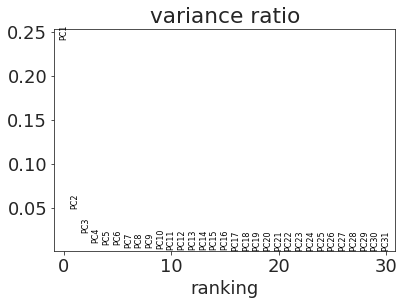

In [30]:
print(SPN_scanpy.obs['id'].value_counts())

sc.pp.pca(SPN_scanpy)
sc.pl.pca_variance_ratio(SPN_scanpy)
